# Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# Etape 1: charger les données

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

import codecs
import re
import os.path

from sklearn.model_selection import train_test_split
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score

In [74]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


In [75]:
path = "./ressources/movies/movies1000/"

alltxts,alllabs = load_movies(path)

In [76]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])


2000 2000
senseless ( r ) marlon wayans is a very talented physical comedian , and it is that gift that brings senseless moments of life . 
alas , moments are simply that , moments , which are not enough to lift this fantasy/comedy above its one-joke premise . 
granted , that one joke is initially amusing . 
when wayans's darryl witherspoon , an economics major at stratford university , hits some dire financial straits , he becomes a guinea pig for a experimental drug that heightens all five senses . 
after some initial side effects and problems controlling his superhuman senses , darryl learns to enjoy the benefits of his abilities and uses them to land a position at a highly esteemed corporate firm . 
at this point , the film sounds more like senseful than senseless , but through some turns of the plot , darryl finds himself only able to use four of his five senses at once , essentially leaving him--yes--senseless . 
this sets up some showcase moments for wayans's gift for physical c

In [77]:
def load_sentiment(path2data): # 1 classe par répertoire
    alltexts = [] # init vide
    labs = []
    alltexts = (open(path2data).readlines()) 
    return alltexts,labs

In [78]:
path = './ressources/movies/testSentiment.txt'

sentiment_txt , sentiment_labs= load_sentiment(path)

In [79]:
print(len(sentiment_txt))
print(sentiment_txt[0]) #un probleme a cause d'un caractère non reconnu 

25000
Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.



-  Création d'un sample pour les tests de vocabulaire pour alléger en temps de calcul

In [80]:
test_para= []
for i in range (5): 
    test_para.append(sentiment_txt[i])

print(test_para[0])

Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.



# Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

[(',', 77717), ('the', 68368), ('.', 65876), ('a', 37123), ('and', 33726), ('of', 33698), ('to', 31471), ('is', 25017), ('in', 20012), ('"', 17612), ('that', 14768), (')', 11781), ('(', 11664), ('it', 10546), ('as', 10422), ('with', 10407), ('for', 9427), ('his', 9008), ('film', 8843), ('this', 7965), ('\nthe', 7810), ('on', 6979), ('are', 6907), ('but', 6798), ('he', 6191), ('be', 6052), ('by', 6039), ('an', 5619), ('i', 5589), ('movie', 5419), ('who', 5306), ('not', 5196), ('one', 5036), ('was', 4903), ('have', 4871), ('from', 4821), ('has', 4706), ('at', 4592), ('her', 4321), ('you', 4052), ('all', 3966), ('?', 3771), ('\n', 3769), ('they', 3628), ('about', 3501), ('out', 3420), ('like', 3387), ('more', 3279), ('so', 3135), ('which', 3098)]


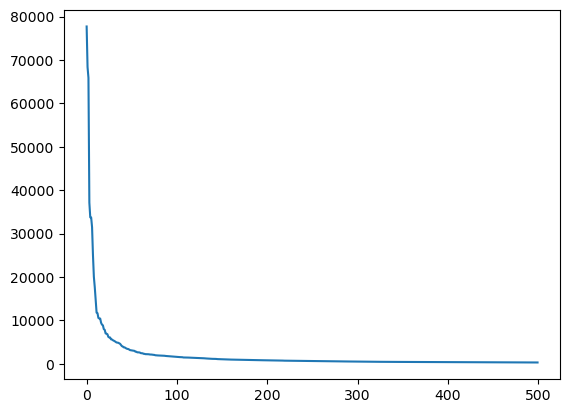

In [81]:
from collections import Counter

wc = Counter()
nb_max = 500

for text in alltxts:
    wc.update(text.split(" ")) 
    
    #considère chaque mot comme étant des unités espacées par un " " 
    
freq = [f for w,f in wc.most_common()]
plt.plot(freq[:nb_max])

print(wc.most_common(50))

on remarque que la ponctuation prend enormément de place dans les mots les plus fréquents

# Retrait de la ponctuation


In [82]:
import string
no_punc = re.sub("'",'',alltxts[0]) #texte en anglais on doit garder les 't de négations
punc = string.punctuation  
punc += '\n\r\t'

no_punc = no_punc.translate(str.maketrans(punc, ' ' * len(punc)))  
no_punc = re.sub('    ',' ',no_punc)
no_punc = re.sub('   ',' ',no_punc)
print(alltxts[0], "\n-->\n", no_punc)

senseless ( r ) marlon wayans is a very talented physical comedian , and it is that gift that brings senseless moments of life . 
alas , moments are simply that , moments , which are not enough to lift this fantasy/comedy above its one-joke premise . 
granted , that one joke is initially amusing . 
when wayans's darryl witherspoon , an economics major at stratford university , hits some dire financial straits , he becomes a guinea pig for a experimental drug that heightens all five senses . 
after some initial side effects and problems controlling his superhuman senses , darryl learns to enjoy the benefits of his abilities and uses them to land a position at a highly esteemed corporate firm . 
at this point , the film sounds more like senseful than senseless , but through some turns of the plot , darryl finds himself only able to use four of his five senses at once , essentially leaving him--yes--senseless . 
this sets up some showcase moments for wayans's gift for physical comedy , es

In [83]:
import unicodedata

doc = unicodedata.normalize('NFD',alltxts[0]).encode('ascii', 'ignore').decode("utf-8")
doc = doc.lower()
print (alltxts[0])
print(doc)

# pas utile pour notre exemple

senseless ( r ) marlon wayans is a very talented physical comedian , and it is that gift that brings senseless moments of life . 
alas , moments are simply that , moments , which are not enough to lift this fantasy/comedy above its one-joke premise . 
granted , that one joke is initially amusing . 
when wayans's darryl witherspoon , an economics major at stratford university , hits some dire financial straits , he becomes a guinea pig for a experimental drug that heightens all five senses . 
after some initial side effects and problems controlling his superhuman senses , darryl learns to enjoy the benefits of his abilities and uses them to land a position at a highly esteemed corporate firm . 
at this point , the film sounds more like senseful than senseless , but through some turns of the plot , darryl finds himself only able to use four of his five senses at once , essentially leaving him--yes--senseless . 
this sets up some showcase moments for wayans's gift for physical comedy , es

In [84]:


def preprocess(x):
    new_list = [0]*len(x)
    i = 0
    for example in x:
        new_list[i] = example
        new_list[i] = re.sub("'",'',example) #texte en anglais on doit garder les 't de négations
        new_list[i] = new_list[i].translate(str.maketrans(punc, ' ' * len(punc)))  
        i += 1
    return new_list

alltxts, sentiment_txt = preprocess(alltxts), preprocess(sentiment_txt)
test_para = preprocess(test_para)
#-->transformation de nos exemples
#print(alltxts[0])
#print(test_para[0])
# CountVectorizer can take a list of stop words as argument.
# Build or download a list of stop word (from NLTK for exemple)



- test de l'effet de retrait de la ponctuation

In [85]:
from sklearn.feature_extraction.text import CountVectorizer

[('', 472459), ('the', 76573), ('a', 38099), ('and', 35581), ('of', 34126), ('to', 31939), ('is', 25206), ('in', 21826), ('that', 15130), ('it', 12350), ('as', 11380), ('with', 10792), ('for', 9961), ('his', 9588), ('this', 9577), ('film', 8936), ('but', 8635), ('he', 7633), ('i', 7533), ('on', 7384), ('are', 6950), ('by', 6262), ('be', 6172), ('its', 5990), ('one', 5794), ('an', 5744), ('not', 5584), ('movie', 5543), ('who', 5393), ('from', 4999), ('at', 4988), ('was', 4939), ('have', 4902), ('has', 4720), ('her', 4521), ('you', 4464), ('all', 4369), ('they', 4289), ('like', 3691), ('so', 3684), ('out', 3637), ('about', 3523), ('up', 3404), ('more', 3350), ('when', 3257), ('which', 3161), ('or', 3146), ('their', 3123), ('what', 3090), ('some', 2986)]


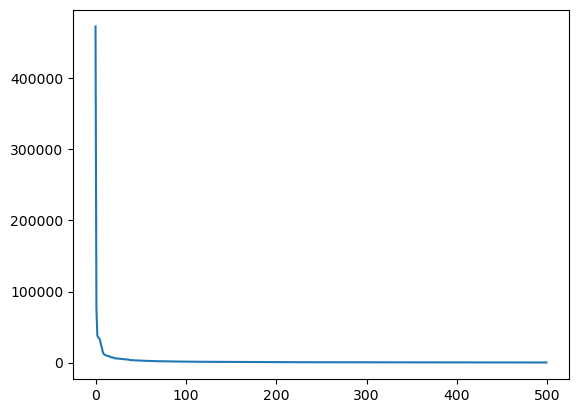

In [86]:
wc = Counter()
nb_max = 500

for text in alltxts:
    wc.update(text.split(" ")) 
    
    #considère chaque mot comme étant des unités espacées par un " " 
    
freq = [f for w,f in wc.most_common()]
plt.plot(freq[:nb_max])

print(wc.most_common(50))


#stop_words = ["the", "a", "and"] #Make a better list

#vectorizer = CountVectorizer(stop_words=stop_words)
#X = vectorizer.fit_transform(test_para)
#print(X)

# Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?


Question qui devient de plus en plus intéressante avec les approches modernes:
est-il possible d'extraire des tri-grammes de lettres pour représenter nos documents?

Quelle performances attendrent? Quels sont les avantages et les inconvénients d'une telle approche?

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
Xcount_train = count.fit_transform(alltxts)
print("Il y a " + str(len(count.get_feature_names())) + " mots dans l'ensemble de training.")
#print(count.get_feature_names())
Xcount_test = count.fit_transform(sentiment_txt)
print("Il y a " + str(len(count.get_feature_names())) + " mots dans l'ensemble de test.")
#print(count.get_feature_names())
Xcount_train = count.fit_transform(test_para)
print("Il y a " + str(len(count.get_feature_names())) + " mots dans l'ensemble de test_para.")
#print(count.get_feature_names())
#vectorizer = CountVectorizer()
#X = vectorizer.fit_transform(corpus)
#print(vectorizer.get_feature_names())

#print(Xcount_train.toarray()[0])

/home/luca/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Il y a 41452 mots dans l'ensemble de training.
Il y a 79109 mots dans l'ensemble de test.
Il y a 623 mots dans l'ensemble de test_para.


In [88]:
wc = Counter()

for text in alltxts:
    wc.update(text.split(" ")) 
    
freq_train = [f for w,f in wc.most_common()]
words_train = [w for w,f in wc.most_common()]

(-0.5, 399.5, 199.5, -0.5)

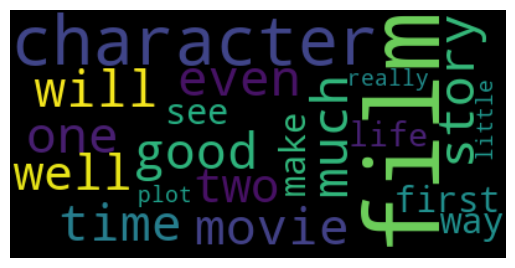

In [90]:
from wordcloud import WordCloud

words_100 = words_train[:100]
words_100 = " ".join(words_100)
wordcloud = WordCloud().generate(words_100)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [48]:
wc = Counter()

for text in sentiment_txt:
    wc.update(text.split(" "))

freq_test = [f for w,f in wc.most_common()]
words_test = [w for w,f in wc.most_common()]

#Création de dictionnaires

freq_train_ = {}
freq_test_ = {}

for i in range(len(words_train)):
    freq_train_[words_train[i]] = freq_train[i]

for i in range(len(words_test)):
    freq_test_[words_test[i]] = freq_test[i]

print(freq_train_["de"])
print(freq_test_["de"])

243
334


In [49]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2count_train = vectorizer2.fit_transform(test_para)
print(vectorizer2.get_feature_names_out())
print(X2count_train.toarray()[1])

['108 minutes' '108 odd' '1970 was' ... 'your teachers'
 'youthful exploits' 'zsigmond future']
[0 0 0 ... 1 0 0]


In [50]:
x_fit, x_boost, y_fit, y_boost = train_test_split(alltxts, alllabs, test_size = 0.33, random_state = 42)

print(len(x_fit), len(y_fit))
print(len(x_boost), len(y_boost))

1340 1340
660 660


# Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

# Construction des tables

In [51]:
#Dataframe split
results_split = pd.DataFrame(columns=['NB', 'Temps_NB', 'LR', 'Temps_LR', 'SVM', 'Temps_SVM'], index=['PP classic', 'ngram=1', 'ngram=2', 'ngram=3', 'stopwords', 'max_features', 'max_def', 'boost'])

#Dataframe Cross-validation
results_cv = pd.DataFrame(columns=['NB', 'Temps_NB', 'LR', 'Temps_LR', 'SVM', 'Temps_SVM'],  index=['PP classic', 'ngram=1', 'ngram=2', 'ngram=3', 'stopwords', 'max_features', 'max_def', 'boost'])


# Application de différents modèles

## Pre-processing classique

### Avec split

In [52]:
vectorizer = CountVectorizer()

x_train_pp_split = vectorizer.fit_transform(x_fit) 
x_test_pp_split = vectorizer.transform(x_boost)

#Naïve Bayes
start_nb = time.time()
mod_nb = MultinomialNB()
mod_nb.fit(x_train_pp_split, y_fit)
end_nb = time.time()
results_split.loc['PP classic', 'NB'] = mod_nb.score(x_test_pp_split, y_boost)
results_split.loc['PP classic', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr = LogisticRegression(random_state=0, C=1e-3)
mod_lr.fit(x_train_pp_split, y_fit)
end_lr = time.time()
results_split.loc['PP classic', 'LR'] = mod_lr.score(x_test_pp_split, y_boost)
results_split.loc['PP classic', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_pp_split, y_fit)
end_svm = time.time()
results_split.loc['PP classic', 'SVM'] = mod_svm.score(x_test_pp_split, y_boost)
results_split.loc['PP classic', 'Temps_SVM'] = end_svm - start_svm

### Avec validation croisée


In [53]:
x_train_pp_cv = vectorizer.fit_transform(alltxts)

#Naïve Bayes
start_nb = time.time()
mod_nb_cv = cross_val_score(mod_nb, x_train_pp_cv, alllabs , cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['PP classic', 'NB'] = mod_nb_cv.mean()
results_cv.loc['PP classic', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr_cv = cross_val_score(mod_lr, x_train_pp_cv, alllabs, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['PP classic', 'LR'] = mod_lr_cv.mean()
results_cv.loc['PP classic', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm_cv = cross_val_score(mod_svm, x_train_pp_cv, alllabs, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['PP classic', 'SVM'] = mod_svm_cv.mean()
results_cv.loc['PP classic', 'Temps_SVM'] = end_svm - start_svm

In [54]:
vectorizer_ngram1 = CountVectorizer(ngram_range=(1,1))

x_train_ng1_split = vectorizer_ngram1.fit_transform(x_fit) 
x_test_ng1_split = vectorizer_ngram1.transform(x_boost)

#Naïve Bayes
start_nb = time.time()
mod_nb = MultinomialNB()
mod_nb.fit(x_train_ng1_split, y_fit)
end_nb = time.time()
results_split.loc['ngram=1', 'NB'] = mod_nb.score(x_test_ng1_split, y_boost)
results_split.loc['ngram=1', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr = LogisticRegression(random_state=0, C=1e-3)
mod_lr.fit(x_train_ng1_split, y_fit)
end_lr = time.time()
results_split.loc['ngram=1', 'LR'] = mod_lr.score(x_test_ng1_split, y_boost)
results_split.loc['ngram=1', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_ng1_split, y_fit)
end_svm = time.time()
results_split.loc['ngram=1', 'SVM'] = mod_svm.score(x_test_ng1_split, y_boost)
results_split.loc['ngram=1', 'Temps_SVM'] = end_svm - start_svm

In [55]:
x_train_ng1_cv = vectorizer_ngram1.fit_transform(alltxts)

#Naïve Bayes
start_nb = time.time()
mod_nb_cv = cross_val_score(mod_nb, x_train_ng1_cv, alllabs, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['ngram=1', 'NB'] = mod_nb_cv.mean()
results_cv.loc['ngram=1', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr_cv = cross_val_score(mod_lr, x_train_ng1_cv, alllabs, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['ngram=1', 'LR'] = mod_lr_cv.mean()
results_cv.loc['ngram=1', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm_cv = cross_val_score(mod_svm, x_train_ng1_cv, alllabs, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['ngram=1', 'SVM'] = mod_svm_cv.mean()
results_cv.loc['ngram=1', 'Temps_SVM'] = end_svm - start_svm

In [56]:
vectorizer_ngram2 = CountVectorizer(ngram_range=(1,2))

x_train_ng2_split = vectorizer_ngram2.fit_transform(x_fit) 
x_test_ng2_split = vectorizer_ngram2.transform(x_boost)

#Naïve Bayes
start_nb = time.time()
mod_nb = MultinomialNB()
mod_nb.fit(x_train_ng2_split, y_fit)
end_nb = time.time()
results_split.loc['ngram=2', 'NB'] = mod_nb.score(x_test_ng2_split, y_boost)
results_split.loc['ngram=2', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr = LogisticRegression(random_state=0, C=1e-3)
mod_lr.fit(x_train_ng2_split, y_fit)
end_lr = time.time()
results_split.loc['ngram=2', 'LR'] = mod_lr.score(x_test_ng2_split, y_boost)
results_split.loc['ngram=2', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_ng2_split, y_fit)
end_svm = time.time()
results_split.loc['ngram=2', 'SVM'] = mod_svm.score(x_test_ng2_split, y_boost)
results_split.loc['ngram=2', 'Temps_SVM'] = end_svm - start_svm

In [57]:
x_train_ng2_cv = vectorizer_ngram2.fit_transform(alltxts)

#Naïve Bayes
start_nb = time.time()
mod_nb_cv = cross_val_score(mod_nb, x_train_ng2_cv, alllabs, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['ngram=2', 'NB'] = mod_nb_cv.mean()
results_cv.loc['ngram=2', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr_cv = cross_val_score(mod_lr, x_train_ng2_cv, alllabs, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['ngram=2', 'LR'] = mod_lr_cv.mean()
results_cv.loc['ngram=2', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm_cv = cross_val_score(mod_svm, x_train_ng2_cv, alllabs, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['ngram=2', 'SVM'] = mod_svm_cv.mean()
results_cv.loc['ngram=2', 'Temps_SVM'] = end_svm - start_svm

In [58]:
vectorizer_ngram3 = CountVectorizer(ngram_range=(1,3))

x_train_ng3_split = vectorizer_ngram3.fit_transform(x_fit) 
x_test_ng3_split = vectorizer_ngram3.transform(x_boost)

#Naïve Bayes
start_nb = time.time()
mod_nb = MultinomialNB()
mod_nb.fit(x_train_ng3_split, y_fit)
end_nb = time.time()
results_split.loc['ngram=3', 'NB'] = mod_nb.score(x_test_ng3_split, y_boost)
results_split.loc['ngram=3', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr = LogisticRegression(random_state=0, C=1e-3)
mod_lr.fit(x_train_ng3_split, y_fit)
end_lr = time.time()
results_split.loc['ngram=3', 'LR'] = mod_lr.score(x_test_ng3_split, y_boost)
results_split.loc['ngram=3', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_ng3_split, y_fit)
end_svm = time.time()
results_split.loc['ngram=3', 'SVM'] = mod_svm.score(x_test_ng3_split, y_boost)
results_split.loc['ngram=3', 'Temps_SVM'] = end_svm - start_svm

In [59]:
x_train_ng3_cv = vectorizer_ngram3.fit_transform(alltxts)

#Naïve Bayes
start_nb = time.time()
mod_nb_cv = cross_val_score(mod_nb, x_train_ng3_cv, alllabs, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['ngram=3', 'NB'] = mod_nb_cv.mean()
results_cv.loc['ngram=3', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr_cv = cross_val_score(mod_lr, x_train_ng3_cv, alllabs, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['ngram=3', 'LR'] = mod_lr_cv.mean()
results_cv.loc['ngram=3', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm_cv = cross_val_score(mod_svm, x_train_ng3_cv, alllabs, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['ngram=3', 'SVM'] = mod_svm_cv.mean()
results_cv.loc['ngram=3', 'Temps_SVM'] = end_svm - start_svm

In [60]:
results_split

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
PP classic,0.818182,0.002841,0.783333,0.233566,0.836364,0.100051
ngram=1,0.818182,0.002401,0.783333,0.337307,0.836364,0.092662
ngram=2,0.854545,0.014766,0.786364,3.377356,0.845455,0.568309
ngram=3,0.842424,0.044962,0.790909,11.914425,0.84697,0.677677
stopwords,NaN,NaN,NaN,NaN,NaN,NaN
max_features,NaN,NaN,NaN,NaN,NaN,NaN
max_def,NaN,NaN,NaN,NaN,NaN,NaN
boost,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
results_cv

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
PP classic,0.8175,0.037322,0.7945,1.704964,0.8435,0.800652
ngram=1,0.8175,0.028447,0.7945,1.712557,0.8435,0.800673
ngram=2,0.8405,0.16955,0.8045,16.222576,0.847,6.507605
ngram=3,0.8405,0.474848,0.8015,65.872433,0.8445,12.678626
stopwords,NaN,NaN,NaN,NaN,NaN,NaN
max_features,NaN,NaN,NaN,NaN,NaN,NaN
max_def,NaN,NaN,NaN,NaN,NaN,NaN
boost,NaN,NaN,NaN,NaN,NaN,NaN


## Première campagne d'expériences

Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

## Amélioration du modèle

### Stopwords

Afin d'améliorer le précédent modèle, nous allons essayer d'enlever les stopwords, c'est-à-dire les mots très fréquents comme "the", "or" etc... qui peuvent s'avérer inutiles à la classification voire qui peuvent fausser les résultats. Mais ces mots peuvent au contraire être nécessaire. C'est ce que nous allons désormais tester.

Concernant les accents, il semble qu'ils n'aient pas une grande importance dans l'apprentissage. Nous avons décidé de ne pas faire de test là-dessus.

In [62]:
wc = Counter()
for text in x_fit:
    wc.update(text.split(" "))
    
stopwords = [w for w,f in wc.most_common(500)]

liste_sw = []
perf_nb_sw = []
perf_lr_sw = []
perf_svm_sw = []

In [63]:
for sw in range(0,550,50):
    liste_sw.append(sw)
    stopwords_sw = stopwords[0:sw]

    vectorizer = CountVectorizer(stop_words=stopwords_sw, ngram_range=(1,3), analyzer='word')
    x_train_sw = vectorizer.fit_transform(x_fit) 
    x_test_sw = vectorizer.transform(x_boost)

    #Naïve Bayes
    mod_nb = MultinomialNB()
    mod_nb.fit(x_train_sw, y_fit)
    perf_nb_sw.append(mod_nb.score(x_test_sw, y_boost))

    #Logistic Regression
    mod_lr = LogisticRegression(random_state=0, C=1e-3)
    mod_lr.fit(x_train_sw, y_fit)
    perf_lr_sw.append(mod_lr.score(x_test_sw, y_boost))

    #Linear SVM
    mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
    mod_svm.fit(x_train_sw, y_fit)
    perf_svm_sw.append(mod_svm.score(x_test_sw, y_boost))

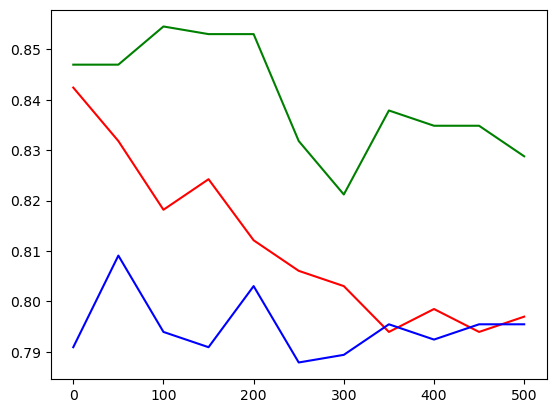

In [64]:
plt.plot(liste_sw, perf_nb_sw, 'r',)
plt.plot(liste_sw, perf_lr_sw, 'b')
plt.plot(liste_sw, perf_svm_sw, 'g')
plt.show()

## Max_features

Cependant, une autre technique pour enlever des mots est le contrôle du paramètre max_features. Si max_features est défini sur None, l'ensemble du corpus est pris en compte lors de la transformation TF-IDF. En ajoutant une valeur à max_features, alors le nombre de mots dans le vocabulaire sera limité à cette valeur. Ainsi, pour d documents et 100 mots, si on met un max_feature à 80, alors la sparse matrix aura comme dimension 3x80 au lieu de 3x100.

In [65]:
liste_feat = []
perf_nb_feat = []
perf_lr_feat = []
perf_svm_feat = []

for feat in range(100,60000,500):
    liste_feat.append(feat)

    vectorizer = CountVectorizer(ngram_range=(1,3), max_features=feat)
    x_train_feat = vectorizer.fit_transform(x_fit) 
    x_test_feat = vectorizer.transform(x_boost)

    #Naïve Bayes
    mod_nb = MultinomialNB()
    mod_nb.fit(x_train_feat, y_fit)
    perf_nb_feat.append(mod_nb.score(x_test_feat, y_boost))

    #Logistic Regression
    mod_lr = LogisticRegression(random_state=0, C=1e-3)
    mod_lr.fit(x_train_feat, y_fit)
    perf_lr_feat.append(mod_lr.score(x_test_feat, y_boost))

    #Linear SVM
    mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
    mod_svm.fit(x_train_feat, y_fit)
    perf_svm_feat.append(mod_svm.score(x_test_feat, y_boost))

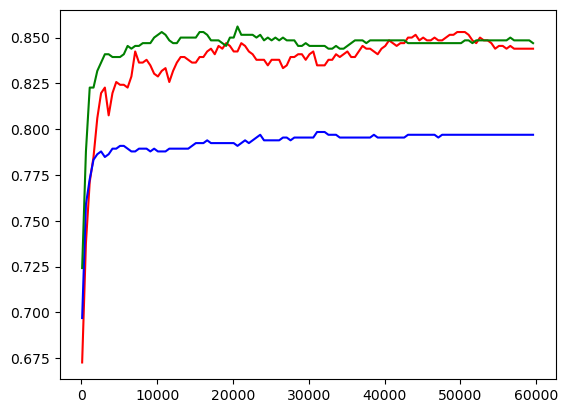

In [66]:
plt.plot(liste_feat, perf_nb_feat, 'r')
plt.plot(liste_feat, perf_lr_feat, 'b')
plt.plot(liste_feat, perf_svm_feat, 'g')
plt.show()

### Max_def

Les stopwords sont les mots qui apparaissent très fréquemment dans l'ensemble du corpus. On peut également éliminer, grâce à la variable max_df, les mots qui apparaissent dans beaucoup de documents différents. Un mot peut ne pas être très fréquent dans l'ensemble mais apparaître dans chaque document et ainsi ne pas être utile à la classification.

In [67]:
liste_df = []
perf_nb_df = []
perf_lr_df = []
perf_svm_df = []

for df in range(1,10000,1000):
    liste_df.append(df)

    vectorizer = CountVectorizer(ngram_range=(1,3), max_df=df)
    x_train_df = vectorizer.fit_transform(x_fit) 
    x_test_df = vectorizer.transform(x_boost)

    #Naïve Bayes
    mod_nb = MultinomialNB()
    mod_nb.fit(x_train_df, y_fit)
    perf_nb_df.append(mod_nb.score(x_test_df, y_boost))

    #Logistic Regression
    mod_lr = LogisticRegression(random_state=0, C=1e-3)
    mod_lr.fit(x_train_df, y_fit)
    perf_lr_df.append(mod_lr.score(x_test_df, y_boost))

    #Linear SVM
    mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
    mod_svm.fit(x_train_df, y_fit)
    perf_svm_df.append(mod_svm.score(x_test_df, y_boost))

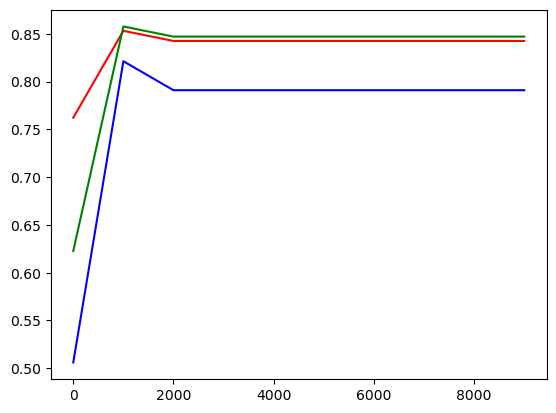

In [68]:
plt.plot(liste_df, perf_nb_df, 'r')
plt.plot(liste_df, perf_lr_df, 'b')
plt.plot(liste_df, perf_svm_df, 'g')
plt.show()

In [69]:
#Naïve Bayes

vectorizer_nb_df = CountVectorizer(ngram_range=(1,3), min_df=1, max_df=liste_df[np.argmax(perf_nb_df)])

x_train_nb_df = vectorizer_nb_df.fit_transform(x_fit) 
x_test_nb_df = vectorizer_nb_df.transform(x_boost)

start_nb = time.time()
mod_nb = MultinomialNB()
mod_nb.fit(x_train_nb_df, y_fit)
end_nb = time.time()
results_split.loc['max_def', 'NB'] = mod_nb.score(x_test_nb_df, y_boost)
results_split.loc['max_def', 'Temps_NB'] = end_nb - start_nb

x_nb_df_cv = vectorizer_nb_df.fit_transform(alltxts)
start_nb = time.time()
mod_nb_cv = cross_val_score(mod_nb, x_nb_df_cv, alllabs, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['max_def', 'NB'] = mod_nb_cv.mean()
results_cv.loc['max_def', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression

vectorizer_lr_df = CountVectorizer(ngram_range=(1,3), min_df=1, max_df=liste_df[np.argmax(perf_lr_df)])

x_train_lr_df = vectorizer_lr_df.fit_transform(x_fit) 
x_test_lr_df = vectorizer_lr_df.transform(x_boost)

start_lr = time.time()
mod_lr = LogisticRegression(random_state=0, C=1e-3)
mod_lr.fit(x_train_lr_df, y_fit)
end_lr = time.time()
results_split.loc['max_def', 'LR'] = mod_lr.score(x_test_lr_df, y_boost)
results_split.loc['max_def', 'Temps_LR'] = end_lr - start_lr

x_lr_df_cv = vectorizer_lr_df.fit_transform(alltxts)
start_lr = time.time()
mod_lr_cv = cross_val_score(mod_lr, x_lr_df_cv, alllabs, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['max_def', 'LR'] = mod_lr_cv.mean()
results_cv.loc['max_def', 'Temps_LR'] = end_nb - start_nb

#Linear SVM

vectorizer_svm_df = CountVectorizer(ngram_range=(1,3), min_df=1, max_df=liste_df[np.argmax(perf_svm_df)])

x_train_svm_df = vectorizer_svm_df.fit_transform(x_fit) 
x_test_svm_df = vectorizer_svm_df.transform(x_boost)

start_svm = time.time()
mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_svm_df, y_fit)
end_svm = time.time()
results_split.loc['max_def', 'SVM'] = mod_svm.score(x_test_svm_df, y_boost)
results_split.loc['max_def', 'Temps_SVM'] = end_svm - start_svm

x_svm_df_cv = vectorizer_svm_df.fit_transform(alltxts)
start_svm = time.time()
mod_svm_cv = cross_val_score(mod_svm, x_svm_df_cv, alllabs, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['max_def', 'SVM'] = mod_svm_cv.mean()
results_cv.loc['max_def', 'Temps_SVM'] = end_svm - start_svm

In [70]:
results_split

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
PP classic,0.818182,0.002841,0.783333,0.233566,0.836364,0.100051
ngram=1,0.818182,0.002401,0.783333,0.337307,0.836364,0.092662
ngram=2,0.854545,0.014766,0.786364,3.377356,0.845455,0.568309
ngram=3,0.842424,0.044962,0.790909,11.914425,0.84697,0.677677
stopwords,NaN,NaN,NaN,NaN,NaN,NaN
max_features,NaN,NaN,NaN,NaN,NaN,NaN
max_def,0.85303,0.043894,0.821212,4.335758,0.857576,0.479797
boost,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
results_cv

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
PP classic,0.8175,0.037322,0.7945,1.704964,0.8435,0.800652
ngram=1,0.8175,0.028447,0.7945,1.712557,0.8435,0.800673
ngram=2,0.8405,0.16955,0.8045,16.222576,0.847,6.507605
ngram=3,0.8405,0.474848,0.8015,65.872433,0.8445,12.678626
stopwords,NaN,NaN,NaN,NaN,NaN,NaN
max_features,NaN,NaN,NaN,NaN,NaN,NaN
max_def,0.8435,0.404528,0.839,0.404528,0.8575,3.972713
boost,NaN,NaN,NaN,NaN,NaN,NaN


# V - Test du modèle sur les données test

In [72]:
sentiment_labs=[]
# Naive bayes

vectorizer_nb_df.fit(x_fit)
x_train_nb = vectorizer_nb_df.fit_transform(x_fit)
x_test_nb = vectorizer_nb_df.transform(sentiment_txt)

mod_nb = MultinomialNB()
mod_nb.fit(x_train_nb, y_fit)

print(mod_nb.score(x_test_nb, sentiment_labs))
pred_nb = mod_nb.predict(x_test_nb)

# Logistic Regression

vectorizer_lr_df.fit(x_fit)
x_train_lr = vectorizer_lr_df.fit_transform(x_fit)
x_test_lr = vectorizer_lr_df.transform(sentiment_labs)

mod_lr = LogisticRegression(random_state=0, C=1e-3)
mod_lr.fit(x_train_lr, y_fit)

print(mod_lr.score(x_test_lr, sentiment_labs))
pred_lr = mod_lr.predict(x_test_lr)

#SVM

vectorizer_svm_df.fit(x_fit)
x_train_svm = vectorizer_svm_df.fit_transform(x_fit)
x_test_svm = vectorizer_svm_df.transform(sentiment_labs)

mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_svm, y_fit)

print(mod_svm.score(x_test_svm, sentiment_labs))
pred_svm = mod_svm.predict(x_test_svm)

ValueError: Found input variables with inconsistent numbers of samples: [0, 25000]

In [ ]:
barwidth = 0.9

plt.bar(x=[1], width=barwidth, height=sum(np.array(y_test)==1)/len(y_test), color='darkgreen', label='Real')
plt.bar(x=[2], width=barwidth, height=sum(pred_nb==1)/len(pred_nb), color='forestgreen', label='NB')
plt.bar(x=[3], width=barwidth, height=sum(pred_lr==1)/len(pred_nb), color='limegreen', label='LR')
plt.bar(x=[4], width=barwidth, height=sum(pred_svm==1)/len(pred_nb), color='springgreen', label='SVM')

plt.bar(x=[6], width=barwidth, height=sum(np.array(y_test)!=1)/len(y_test), color='darkgreen')
plt.bar(x=[7], width=barwidth, height=sum(pred_nb!=1)/len(pred_nb), color='forestgreen')
plt.bar(x=[8], width=barwidth, height=sum(pred_lr!=1)/len(pred_nb), color='limegreen')
plt.bar(x=[9], width=barwidth, height=sum(pred_svm!=1)/len(pred_nb), color='springgreen')

plt.xticks([r for r in [2.5, 7.5]], ['Prediction = 1', 'Prediction = -1'])

plt.legend()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(results_split['NB'], 'b')
plt.plot(results_split['LR'], 'r')
plt.plot(results_split['SVM'], 'g')
plt.legend(['NB', 'LR', 'SVM'])
plt.title('Evolution de la performance (accuracy) avec le prétraitement selon les modèles')